1. Laden Sie die Trainingsdaten.

In [77]:
import pandas as pd

train_df =  pd.read_csv('data/train.csv', delimiter=';')
train_df.head()

,transactionId,basket,customerType,totalAmount,returnLabel
0,9534310106,"[4, 3, 4]",new,252.0,1
1,7202594767,"[4, 2, 0, 2, 5]",existing,70.0,0
2,2737331698,[5],existing,84.0,0
3,4868011733,"[1, 4, 2, 4]",existing,116.0,0
4,7622406570,"[2, 5, 3, 2, 3, 2, 0]",existing,378.0,0


2. Führen Sie eine kurze EDA durch (Details auf Folie 13).

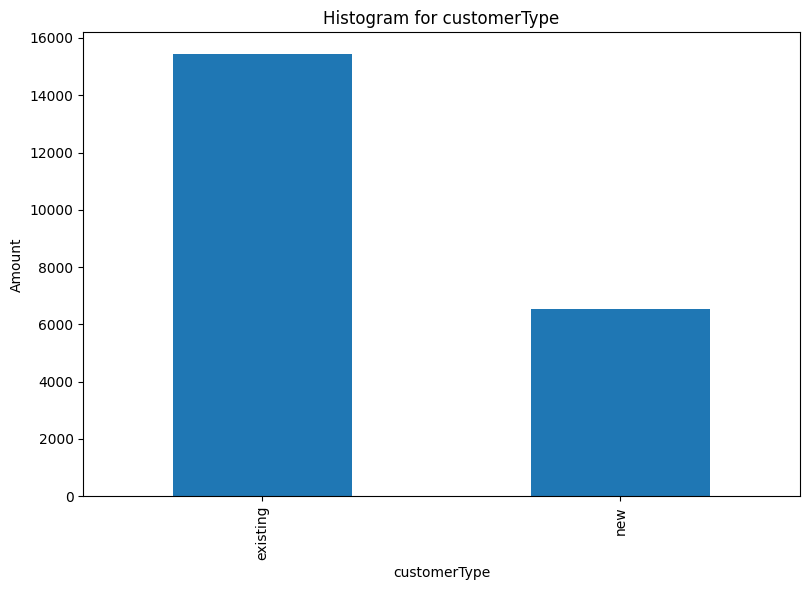

In [78]:
import matplotlib.pyplot as plt

ax = train_df['customerType'].value_counts().plot.bar(figsize=(8, 6), title='Histogram for customerType')
plt.tight_layout()
ax.set_ylabel('Amount')
plt.show()

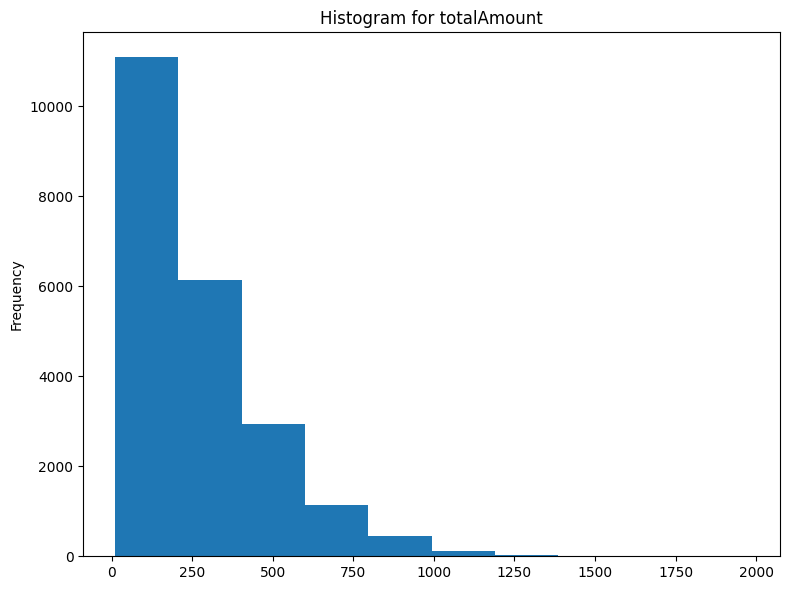

In [79]:
train_df['totalAmount'].plot.hist(bins=10, figsize=(8, 6), title='Histogram for totalAmount')
plt.tight_layout()
plt.show()

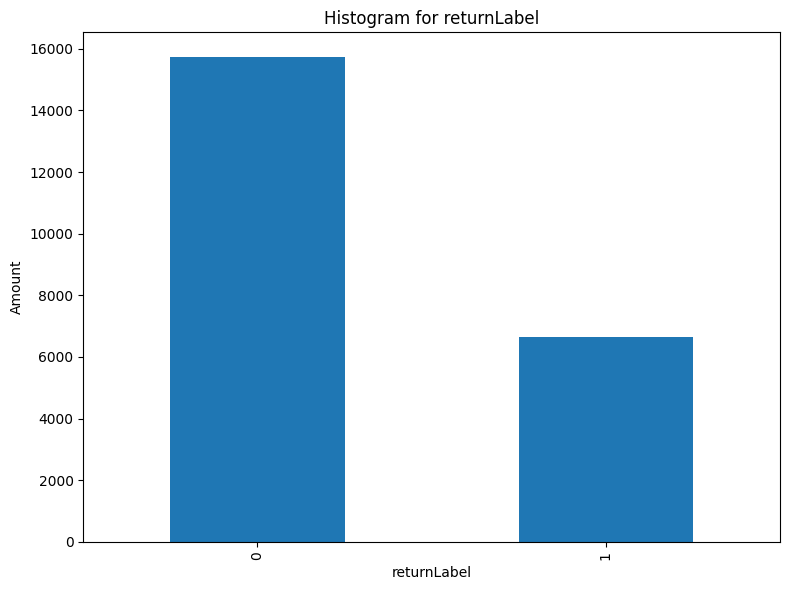

In [80]:
ax = train_df['returnLabel'].value_counts().plot.bar(figsize=(8, 6), title='Histogram for returnLabel')

ax.set_ylabel('Amount')
plt.tight_layout()
plt.show()

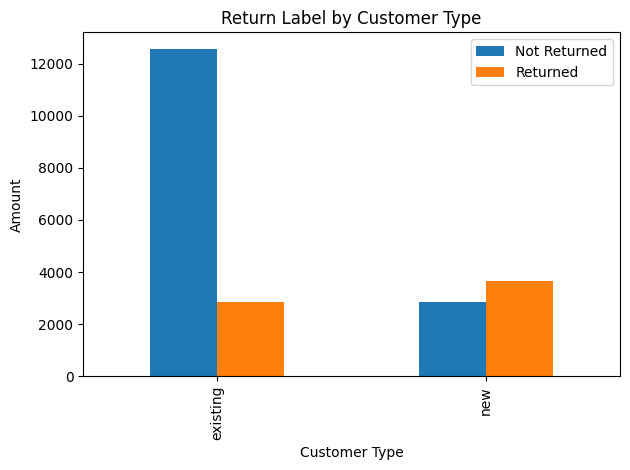

In [81]:
return_by_customer = train_df.groupby(['customerType', 'returnLabel']).size().unstack(fill_value=0)
ax =return_by_customer.plot.bar(title='Return Label by Customer Type')
ax.set_ylabel('Amount')
ax.set_xlabel('Customer Type')
ax.legend(['Not Returned', 'Returned'])

plt.tight_layout()
plt.show()


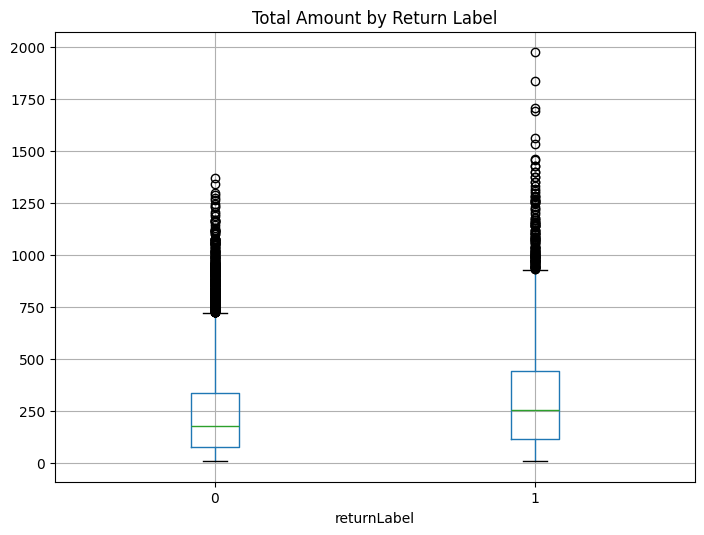

In [82]:
train_df.boxplot(column='totalAmount', by='returnLabel', figsize=(8, 6))
plt.title('Total Amount by Return Label')
plt.suptitle('')
plt.show()


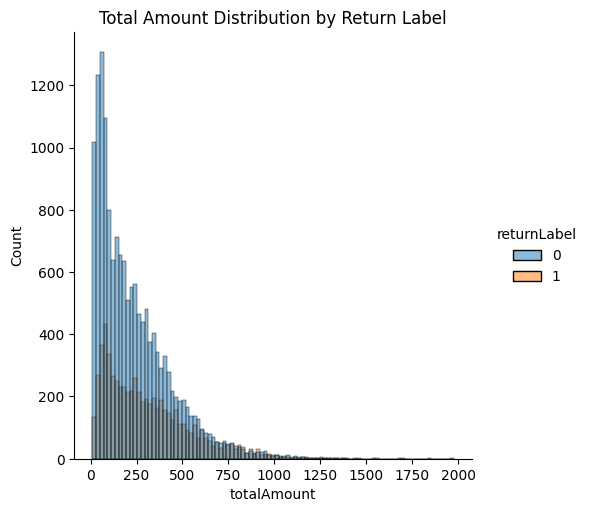

In [83]:
import seaborn as sns
sns.displot(train_df, x='totalAmount', hue='returnLabel', kind='hist')
plt.title('Total Amount Distribution by Return Label')
plt.show()

3. Füllen Sie fehlende Werte in den Trainingsdaten auf.


In [84]:
basket_nan1 = train_df['basket'].isna().sum()
customerType_nan1 = train_df['customerType'].isna().sum()
totalAmount_nan1 = train_df['totalAmount'].isna().sum()
returnLabel_nan1 = train_df['returnLabel'].isna().sum()
nan_values1 = train_df.isna().sum().sum()

print(f'Der Datensatz before filled enthält {nan_values1} NaN-Werte.')
print(f'basket enthält {basket_nan1} NaN-Werte.')
print(f'customerType enthält {customerType_nan1} NaN-Werte.')
print(f'totalAmount enthält {totalAmount_nan1} NaN-Werte.')
print(f'returnLabel enthält {returnLabel_nan1} NaN-Werte.\n')

train_df['totalAmount'] = train_df['totalAmount'].fillna(train_df['totalAmount'].mean())
train_df['customerType'] = train_df['customerType'].fillna(train_df['customerType'].mode()[0])

basket_nan = train_df['basket'].isna().sum()
customerType_nan = train_df['customerType'].isna().sum()
totalAmount_nan = train_df['totalAmount'].isna().sum()
returnLabel_nan = train_df['returnLabel'].isna().sum()
nan_values = train_df.isna().sum().sum()

print(f'Der Datensatz after filled enthält {nan_values} NaN-Werte.')
print(f'basket enthält {basket_nan} NaN-Werte.')
print(f'customerType enthält {customerType_nan} NaN-Werte.')
print(f'totalAmount enthält {totalAmount_nan} NaN-Werte.')
print(f'returnLabel enthält {returnLabel_nan} NaN-Werte.')


Der Datensatz before filled enthält 919 NaN-Werte.
basket enthält 0 NaN-Werte.
customerType enthält 442 NaN-Werte.
totalAmount enthält 477 NaN-Werte.
returnLabel enthält 0 NaN-Werte.

Der Datensatz after filled enthält 0 NaN-Werte.
basket enthält 0 NaN-Werte.
customerType enthält 0 NaN-Werte.
totalAmount enthält 0 NaN-Werte.
returnLabel enthält 0 NaN-Werte.


4. Transformieren Sie die kategorischen Features mittels One-hot-encoding.

In [85]:
oh_train_df = pd.get_dummies(train_df, columns=['customerType', 'returnLabel'])
oh_train_df.head()

,transactionId,basket,totalAmount,customerType_existing,customerType_new,returnLabel_0,returnLabel_1
0,9534310106,"[4, 3, 4]",252.0,False,True,False,True
1,7202594767,"[4, 2, 0, 2, 5]",70.0,True,False,True,False
2,2737331698,[5],84.0,True,False,True,False
3,4868011733,"[1, 4, 2, 4]",116.0,True,False,True,False
4,7622406570,"[2, 5, 3, 2, 3, 2, 0]",378.0,True,False,True,False


5. Versuchen Sie auf Basis des Attributs basket Features zu bauen (z.B. wie oft
kommt jede Kategorie im Basket vor)

In [86]:
def parse_basket(basket_str):
    basket_list = eval(basket_str)
    return basket_list

def create_basket_features(df):
    df = df.copy()
    df['basket_parsed'] = df['basket'].apply(parse_basket)
    
    df['basket_Amount'] = df['basket_parsed'].apply(len)
    
    for i in range(6):
        df[f'category_{i}'] = df['basket_parsed'].apply(lambda x: x.count(i))
    
    return df

train_features = create_basket_features(oh_train_df)

y_train = train_features['returnLabel_1']

feature_columns = ['totalAmount', 'basket_Amount'] + [f'category_{i}' for i in range(6)] + ['customerType_existing', 'customerType_new']

X_train = train_features[feature_columns]

print("Feature matrix shape:", X_train.shape)
print("Features:", X_train.columns.tolist())

Feature matrix shape: (22400, 10)
Features: ['totalAmount', 'basket_Amount', 'category_0', 'category_1', 'category_2', 'category_3', 'category_4', 'category_5', 'customerType_existing', 'customerType_new']


6. Skalieren Sie die Features mit einem StandardScaler.

In [87]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

print(X_train_scaled)
print("Feature matrix shape after scaling:", X_train_scaled.shape)

[[-0.03282349 -0.60727524 -0.77156277 ... -0.64410553 -1.55861197
   1.55861197]
 [-0.87945944  0.13320354  0.38348676 ...  0.52709049  0.64159651
  -0.64159651]
 [-0.8143336  -1.34775403 -0.77156277 ...  0.52709049  0.64159651
  -0.64159651]
 ...
 [-0.04677903 -0.60727524  0.38348676 ... -0.64410553 -1.55861197
   1.55861197]
 [-0.83294098  1.24392171  0.38348676 ...  2.86948253  0.64159651
  -0.64159651]
 [ 1.08361952 -0.23703585  0.38348676 ... -0.64410553 -1.55861197
   1.55861197]]
Feature matrix shape after scaling: (22400, 10)


7. Trainieren Sie die folgenden Klassifikationsmodelle und probieren Sie die
angegebenen Hyperparameter mittels Cross-Validation aus:
    1. Logistische Regression: C :[0.1,1,4,5,6,10,30,100] und penalty: ["l1", "l2"]
    2. Random Forest: n_estimators: [60,80,100,120,140] und max_depth: [2, 4, 6]
    3. Gradient Boosting Tree: gleiche Hyperparameter wie bei Random Forest.

1. Logistische Regression: 

In [116]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

logreg = LogisticRegression(solver='liblinear', max_iter=1000)

logreg_p = {'C': [0.1, 1, 4, 5, 6, 10, 30, 100], 'penalty': ['l1', 'l2']}

logreg_grid = GridSearchCV(logreg, logreg_p, cv=5, scoring='accuracy')
logreg_grid.fit(X_train_scaled, y_train)

best_logreg = logreg_grid.best_estimator_

print("Beste Parameter mit Logistische Regression:", logreg_grid.best_params_)
print('Best score:', logreg_grid.best_score_)



Beste Parameter mit Logistische Regression: {'C': 1, 'penalty': 'l1'}
Best score: 0.8787053571428572


 2. Random Forest:

In [114]:
from sklearn.ensemble import RandomForestClassifier

rdmF = RandomForestClassifier(random_state=0)

rdmF_p = {'n_estimators': [60, 80, 100, 120, 140], 'max_depth': [2, 4, 6]}

rdmF_grid = GridSearchCV(rdmF, rdmF_p, cv=5, scoring='accuracy')
rdmF_grid.fit(X_train_scaled, y_train)

best_rdmF = rdmF_grid.best_estimator_

print("Beste Parameter mit RandomForestClassifier:", rdmF_grid.best_params_)
print('Best score:', rdmF_grid.best_score_)


Beste Parameter mit RandomForestClassifier: {'max_depth': 6, 'n_estimators': 140}
Best score: 0.8687946428571429


3. Gradient Boosting Tree

In [115]:
from sklearn.ensemble import GradientBoostingClassifier

gradB = GradientBoostingClassifier(random_state=0)

gradB_p = {'n_estimators': [60, 80, 100, 120, 140], 'max_depth': [2, 4, 6]}

gradB_grid = GridSearchCV(gradB, gradB_p, cv=5, scoring='accuracy')
gradB_grid.fit(X_train_scaled, y_train)

best_gradB = gradB_grid.best_estimator_

print("Beste Parameter mit GradientBoostingClassifier:", gradB_grid.best_params_)
print('Best score:', gradB_grid.best_score_)



Beste Parameter mit GradientBoostingClassifier: {'max_depth': 4, 'n_estimators': 80}
Best score: 0.8783035714285713


8. Laden Sie die Testdaten

In [103]:
test_df =  pd.read_csv('data/test.csv', delimiter=';')
test_df.head()

,transactionId,basket,customerType,totalAmount,returnLabel
0,4132523932,"[4, 3, 4, 3, 2, 3]",existing,366.0,1
1,8998574539,"[3, 4, 4, 3, 5]",existing,85.0,0
2,9346688547,"[1, 1, 2, 2, 4, 4, 3, 1, 1, 0, 3]",existing,275.0,0
3,4533897707,"[3, 2, 2, 1, 5, 1, 1, 0]",existing,528.0,0
4,3334800500,"[4, 2, 3, 5, 2, 5, 1]",existing,287.0,0


9. Entfernen Sie alle Zeilen mit fehlenden Werten

In [104]:
nan_values2 = test_df.isna().sum().sum()
print(f'Der Datensatz before dropna enthält {nan_values1} NaN-Werte.')
test_df_clean = test_df.dropna()
print(f'Der Datensatz after dropna enthält {nan_values} NaN-Werte.')

Der Datensatz before dropna enthält 919 NaN-Werte.
Der Datensatz after dropna enthält 0 NaN-Werte.


10. Transformieren Sie die Attribute genauso wie bei den Trainingsdaten.

In [105]:
oh_test_df = pd.get_dummies(test_df_clean, columns=['customerType', 'returnLabel'])
oh_test_df.head()

,transactionId,basket,totalAmount,customerType_existing,customerType_new,returnLabel_0,returnLabel_1
0,4132523932,"[4, 3, 4, 3, 2, 3]",366.0,True,False,False,True
1,8998574539,"[3, 4, 4, 3, 5]",85.0,True,False,True,False
2,9346688547,"[1, 1, 2, 2, 4, 4, 3, 1, 1, 0, 3]",275.0,True,False,True,False
3,4533897707,"[3, 2, 2, 1, 5, 1, 1, 0]",528.0,True,False,True,False
4,3334800500,"[4, 2, 3, 5, 2, 5, 1]",287.0,True,False,True,False


11. Skalieren Sie die Daten im gleichem Maß wie die Trainingsdaten

In [106]:
def parse_basket(basket_str):
    basket_list = eval(basket_str)
    return basket_list

def create_basket_features(df):
    df = df.copy()
    df['basket_parsed'] = df['basket'].apply(parse_basket)
    
    df['basket_Amount'] = df['basket_parsed'].apply(len)
    
    for i in range(6):
        df[f'category_{i}'] = df['basket_parsed'].apply(lambda x: x.count(i))
    
    return df

test_features = create_basket_features(oh_test_df)

y_test = test_features['returnLabel_1']

feature_columns = ['totalAmount', 'basket_Amount'] + [f'category_{i}' for i in range(6)] + ['customerType_existing', 'customerType_new']

X_test = test_features[feature_columns]

print("Feature matrix shape:", X_test.shape)
print("Features:", X_test.columns.tolist())

Feature matrix shape: (9226, 10)
Features: ['totalAmount', 'basket_Amount', 'category_0', 'category_1', 'category_2', 'category_3', 'category_4', 'category_5', 'customerType_existing', 'customerType_new']


In [107]:
scaler = StandardScaler()
X_test_scaled = scaler.fit_transform(X_test)

print(X_test_scaled)
print("Feature matrix shape after scaling:", X_test_scaled.shape)

[[ 0.46235435  0.49673189 -0.77749516 ... -0.65266341  0.64187131
  -0.64187131]
 [-0.80029305  0.12898607 -0.77749516 ...  0.52524595  0.64187131
  -0.64187131]
 [ 0.0534543   2.33546101  0.3879265  ... -0.65266341  0.64187131
  -0.64187131]
 ...
 [-0.61606336 -1.34199722 -0.77749516 ... -0.65266341  0.64187131
  -0.64187131]
 [-0.86769416  0.86447772  1.55334817 ...  0.52524595  0.64187131
  -0.64187131]
 [-0.54416885 -0.9742514  -0.77749516 ... -0.65266341  0.64187131
  -0.64187131]]
Feature matrix shape after scaling: (9226, 10)


12. Machen Sie eine Vorhersage auf den Testdaten mit allen drei Modellen und den
jeweils besten Hyperparametern aus der Cross Validation.

In [108]:

y_pred_logreg = best_logreg.predict(X_test_scaled)
y_pred_gradB = best_gradB.predict(X_test_scaled)
y_pred_rdmF = best_rdmF.predict(X_test_scaled)



13. Berechnen Sie für jedes der drei Modell Accuracy, Precision und Recall.

In [109]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

print("LogisticRegression Test Accuracy:", accuracy_score(y_test, y_pred_logreg), "Precision:", precision_score(y_test, y_pred_logreg), "Recall:", recall_score(y_test, y_pred_logreg))
print("GradientBoosting Test Accuracy:", accuracy_score(y_test, y_pred_gradB), "Precision:", precision_score(y_test, y_pred_gradB), "Recall:", recall_score(y_test, y_pred_gradB))
print("RandomForest Test Accuracy:", accuracy_score(y_test, y_pred_rdmF), "Precision:", precision_score(y_test, y_pred_rdmF), "Recall:", recall_score(y_test, y_pred_rdmF))



LogisticRegression Test Accuracy: 0.8727509213093432 Precision: 0.8098039215686275 Recall: 0.7498184458968773
GradientBoosting Test Accuracy: 0.8731844786473011 Precision: 0.8011406844106463 Recall: 0.7650689905591866
RandomForest Test Accuracy: 0.862237155863863 Precision: 0.7955360701474691 Recall: 0.7247639796659404


14. Berechnen Sie außerdem die Accuracy auf den Trainingsdaten und vergleichen Sie
Accuracy auf Trainings- und Testdaten. Liegt Overfitting vor? (Unterschied > 5%)

In [117]:
y_train_pred_logreg = best_logreg.predict(X_train_scaled)
y_train_pred_gradB = best_gradB.predict(X_train_scaled)
y_train_pred_rdmF = best_rdmF.predict(X_train_scaled)

acc_train_logreg = accuracy_score(y_train, y_train_pred_logreg)
acc_train_gradB = accuracy_score(y_train, y_train_pred_gradB)
acc_train_rdmF = accuracy_score(y_train, y_train_pred_rdmF)

acc_test_logreg = accuracy_score(y_test, y_pred_logreg)
acc_test_gradB = accuracy_score(y_test, y_pred_gradB)
acc_test_rdmF = accuracy_score(y_test, y_pred_rdmF)

def compare_accuracy(model_name, acc_train, acc_test):
    diff = acc_train - acc_test
    print(f"\n {model_name}")
    print(f"Train Accuracy: {acc_train:.4f}")
    print(f"Test Accuracy: {acc_test:.4f}")
    print(f"Unterschied   : {diff:.4f}")
    if diff > 0.05:
        print("Overfitting liegt vor der Unterschied ist > 5%)")
    else:
        print("Kein Overfitting der Unterschied ist ≤ 5%)")


compare_accuracy("Logistic Regression", acc_train_logreg, acc_test_logreg)
compare_accuracy("Gradient Boosting", acc_train_gradB, acc_test_gradB)
compare_accuracy("Random Forest", acc_train_rdmF, acc_test_rdmF)


 Logistic Regression
Train Accuracy: 0.8784
Test Accuracy: 0.8728
Unterschied   : 0.0057
Kein Overfitting der Unterschied ist ≤ 5%)

 Gradient Boosting
Train Accuracy: 0.8841
Test Accuracy: 0.8732
Unterschied   : 0.0109
Kein Overfitting der Unterschied ist ≤ 5%)

 Random Forest
Train Accuracy: 0.8719
Test Accuracy: 0.8622
Unterschied   : 0.0096
Kein Overfitting der Unterschied ist ≤ 5%)


15. Untersuchen Sie wieviele Datenpunkte es in den Testdaten gibt, welche von allen
drei Modellen falsch klassifiziert wurden:
    1. Bestimmen Sie für jedes der drei Modelle die Indizes der Testdatenpunkte auf
    welchen das jeweilige Modell falsch klassifiziert hat.
    2. Nutzen Sie die set-Klasse in Python um die Anzahl an Datenpunkten zu
    bestimmen, welche von allen drei Modellen falsch klassifiziert wurden.

16. Vergleichen Sie die Feature-Importances der drei Modelle in einem Plot